In [4]:
import pandas as pd
df = pd.read_csv("kidney_disease.csv")



In [5]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [6]:
print(df.head())


   id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 columns]


In [7]:

print(df.isna().sum())

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64


In [8]:
import numpy as np

# Replace "?" with NaN
df = df.replace("?", np.nan)




In [9]:
num_cols = ['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

In [10]:
from sklearn.impute import SimpleImputer
cat_cols = ['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

In [11]:
print(df.isnull().sum())


id                0
age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64


Encode Categorical Variables

Machine learning models can’t work directly with strings (yes/no, normal/abnormal), so encode them.

In [12]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']
encoders = {}

for col in cat_cols:
    df[col] = df[col].fillna("unknown")   # fix: handle NaN safely
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le


feature scaling step:

his one line makes sure all numeric columns have mean 0 and std 1, so they’re directly comparable and ready for ML models.

In [28]:
import joblib
from sklearn.preprocessing import StandardScaler

# suppose df is your dataset
num_cols = df.select_dtypes(include=['int64','float64']).columns  

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# save (dump) the scaler
joblib.dump(scaler, "kidney_scaler.pkl")
print("Scaler saved successfully!")



Scaler saved successfully!


In [14]:
df.to_csv("processed_kidney.csv", index=False)


Exploratory Data Analysis (EDA)

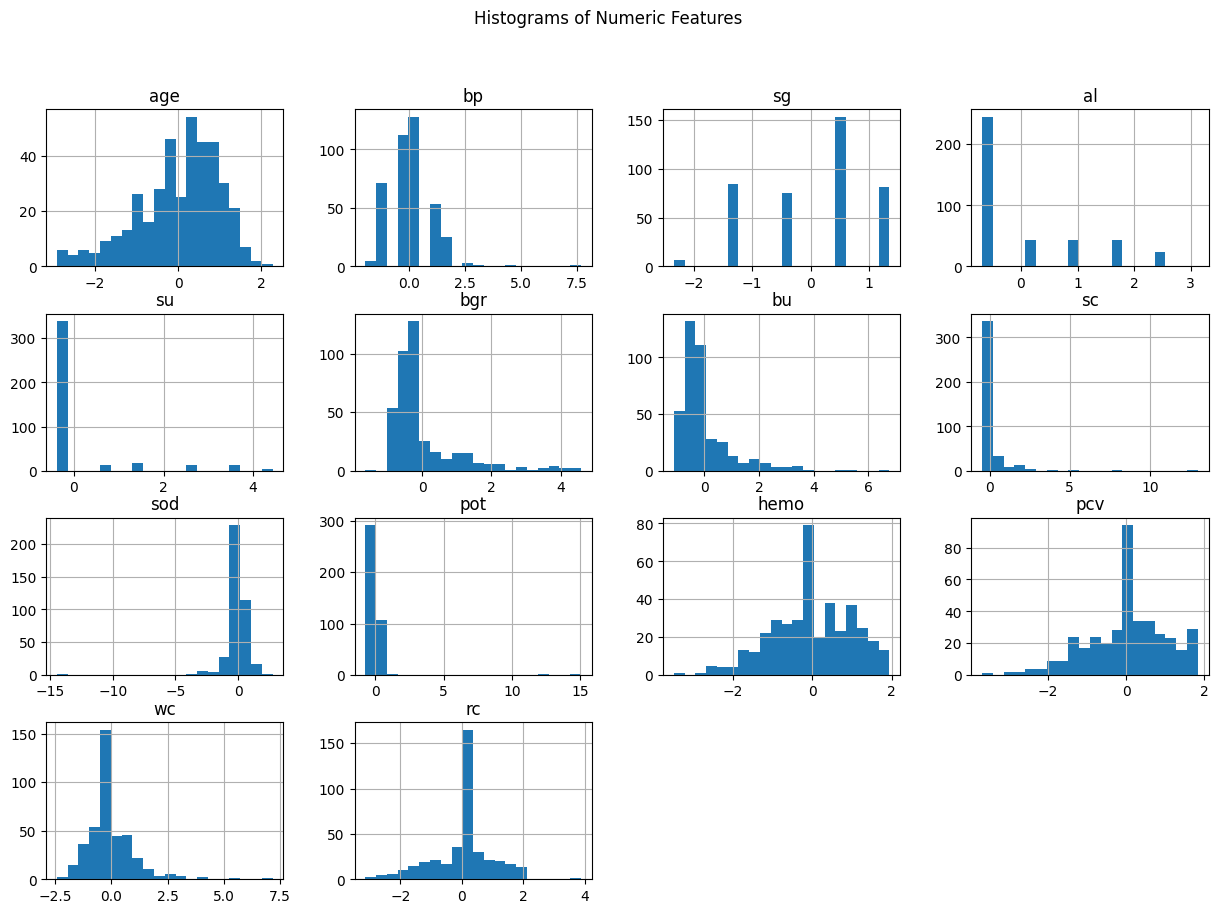

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

df[num_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Features")
plt.show()


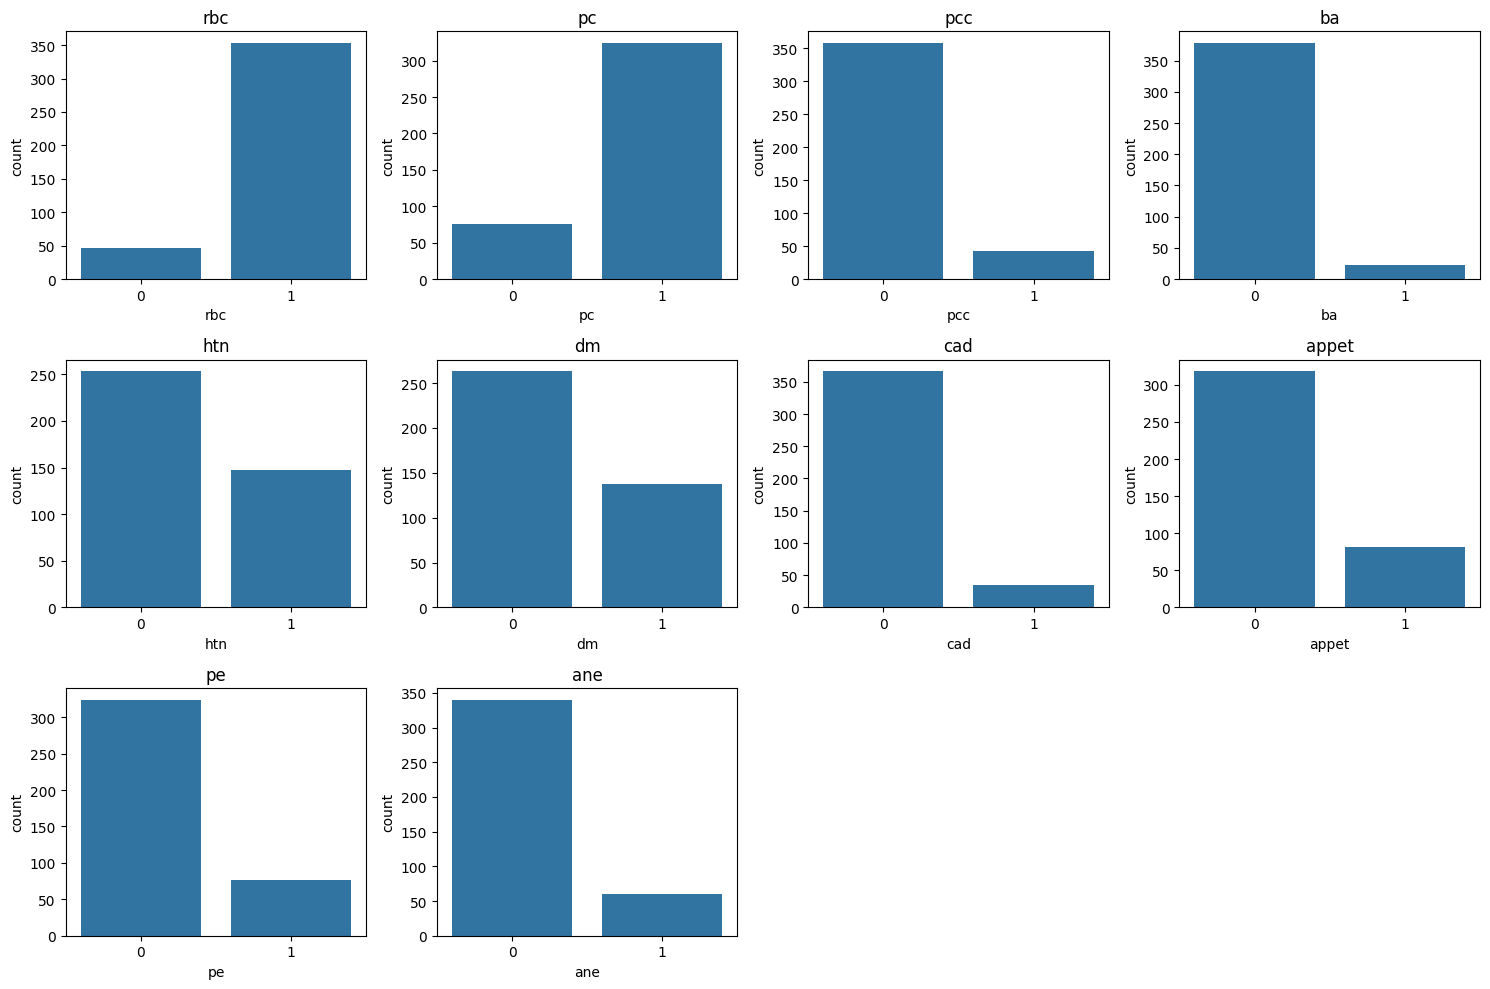

In [16]:
plt.figure(figsize=(15,10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3,4,i)
    sns.countplot(data=df, x=col)
    plt.title(col)
plt.tight_layout()
plt.show()


Model Training + Evaluation

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [18]:
# Example: Kidney dataset
df = pd.read_csv("processed_kidney.csv")

# Features and target
X = df.drop(["classification","id"], axis=1)   # independent vars
y = df["classification"]                # target (0 = no disease, 1 = disease)


In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)   # ckd → 1, notckd → 0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))


RF Accuracy: 0.975



Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        50
           1       1.00      0.93      0.97        30

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80



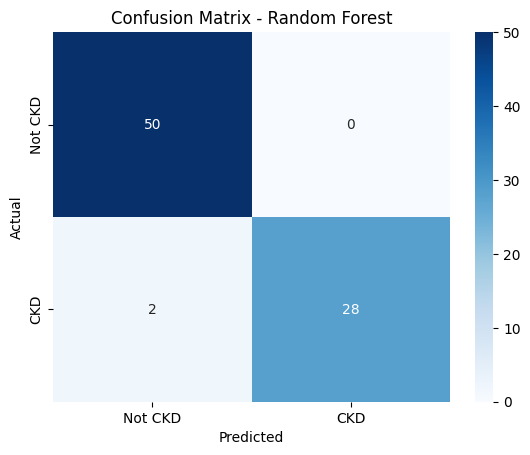

ROC-AUC Score: 0.9993333333333334


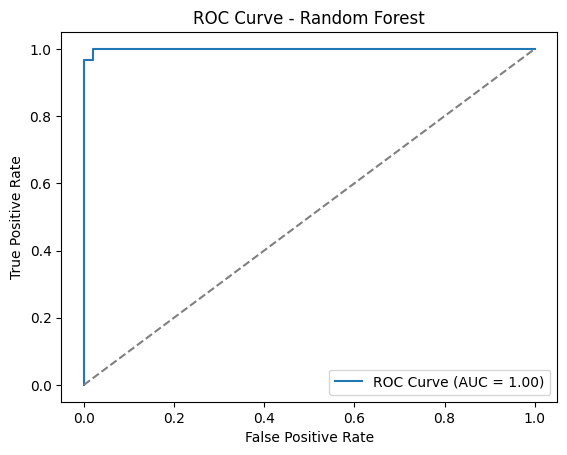

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not CKD", "CKD"], yticklabels=["Not CKD", "CKD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ROC-AUC score
y_proba = rf.predict_proba(X_test)[:,1]  # probability of CKD
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


In [23]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))



Logistic Regression Accuracy: 0.9875

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.97      1.00      0.98        30

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_rf)

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 0.025
RMSE: 0.15811388300841897


MAE = 0.025
→ On average, the model’s predictions are only 2.5% off from the actual values (almost perfect classification).

RMSE = 0.158
→ Slightly higher than MAE because RMSE penalizes bigger errors more. But still very small → model is consistent and stable.

In [25]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print("Cross-validated ROC-AUC scores:", scores)
print("Mean ROC-AUC:", scores.mean())


Cross-validated ROC-AUC scores: [1.         1.         0.99833333 1.         1.        ]
Mean ROC-AUC: 0.9996666666666666


In [26]:
import joblib
joblib.dump(rf, "kidney_rf_model.pkl")

['kidney_rf_model.pkl']

In [27]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

NameError: name 'x' is not defined